In [1]:
# import libraries
import numpy as np
import pandas as pd
import random
import csv
import scipy.stats as stats
import seaborn as sns
from collections import Counter
from collections import defaultdict
import math
from sklearn.linear_model import ElasticNet
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from random import randint
from sklearn.linear_model import Ridge
from sklearn import linear_model

import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm

# initialize the plotting sizes
# set size
plt.rc('figure', figsize=(15, 8))
# subplots size
fizsize_with_subplots = (15, 8)
# histogram size
bin_size = 10

In [2]:
# Loading data
dates = pd.read_csv('data/dates.csv',header=None)
queries = pd.read_csv('data/queries.csv',header=None)
X = pd.read_csv('data/X.csv',header=None)
y = pd.read_csv('data/y.csv',header=None)

X.columns = queries

In [3]:
# data preprocessing and train-test split
# this data is well formed with no missing value and other symbols or labels that are non numerical.
# splitting the data into train and test

# Here we want the first 500 queries
X = X.iloc[:, 0: 100]

# first with the last year as test
# for convinience, pick the two validation set starting from 1/3 and 2/3 of the training set,
# 10% of training set as validation, here use 400 data points, two 200 periods.
test_size =365
length = X.shape[0]
l =(X.shape[0]-test_size)//3

train1_X = pd.concat([X[0:l],X[l+200:2*l],X[2*l+200:length-test_size]])
val1_X = pd.concat([X[l:l+200],X[2*l:2*l+200]])
train1_y = pd.concat([y[0:l],y[l+200:2*l],y[2*l+200:length-test_size]])
val1_y = pd.concat([y[l:l+200],y[2*l:2*l+200]])
test1_X = X[length-test_size:]
test1_y = y[length-test_size:]

# second with the last 2 year as test
test_size2 =365*2
l2 =(X.shape[0]-test_size2)//3

train2_X = pd.concat([X[0:l2],X[l2+180:2*l2],X[2*l2+180:length-test_size2]])
val2_X = pd.concat([X[l2:l2+180],X[2*l2:2*l2+180]])
train2_y = pd.concat([y[0:l2],y[l2+180:2*l2],y[2*l2+180:length-test_size2]])
val2_y = pd.concat([y[l2:l2+180],y[2*l2:2*l2+180]])
test2_X = X[length-test_size2:length-test_size]
test2_y = y[length-test_size2:length-test_size]

print('X shape: ',X.shape,'  y shape: ',y.shape)
print('train1 X:',train1_X.shape,' train1 y:',train1_y.shape,' Test1 X shape:',test1_X.shape, ' Test1 y shape:',test1_y.shape)
print('validation1 X:',val1_X.shape,' validation1 y:',val1_y.shape)
print('train2 X:',train2_X.shape,' train2 y:',train2_y.shape,' Test2 X:',test2_X.shape,' Test2 y:',test2_y.shape)
print('validation2 X:',val2_X.shape,' validation2 y:',val2_y.shape)

X shape:  (4383, 100)   y shape:  (4383, 1)
train1 X: (3618, 100)  train1 y: (3618, 1)  Test1 X shape: (365, 100)  Test1 y shape: (365, 1)
validation1 X: (400, 100)  validation1 y: (400, 1)
train2 X: (3293, 100)  train2 y: (3293, 1)  Test2 X: (365, 100)  Test2 y: (365, 1)
validation2 X: (360, 100)  validation2 y: (360, 1)


In [4]:
train_size = train1_X.shape[0]
corrs = np.zeros((X.shape[1],1))
for i in range(0,X.shape[1]):
    if X.sum(axis=1)[i] == 0:
        corrs[i] = 0
    else:
        corrs[i] = np.corrcoef(train1_X.iloc[0:train_size,i],train1_y.iloc[0:train_size,0])[0,1]
        
corrs.shape,X.columns.shape,X.columns[0],X.columns[99]

((100, 1), (100,), ('flu',), ('the flu jab',))

In [5]:
def corr_filter(df_X,df_Xval,df_Xtest,corrs,threshold):
    X = df_X.copy()
    X_test = df_Xtest.copy()
    X_val = df_Xval.copy()
    col_corr = set() # Set of all the names of deleted columns
    for i in range(0,100):
            if corrs[i,0] < threshold: 
                #print(X.columns[i])
                colname = df_X.columns[i]
                del X[colname] # deleting the column from the dataset
                del X_test[colname] 
                del X_val[colname]

    return X,X_val,X_test

## Fixing pearson correlation filter r>=0.2

In [6]:
#train1_X0,test1_X0 = corr_filter(train1_X,test1_X,corrs,0.1)
train1_X1,val1_X1,test1_X1 = corr_filter(train1_X,val1_X,test1_X,corrs,0.2)
#train1_X2,test1_X2 = corr_filter(train1_X,test1_X,corrs,0.3)
#train1_X3,test1_X3 = corr_filter(train1_X,test1_X,corrs,0.4)

In [7]:
#print('For correlation filter r>=0.1, we select feature number: ',train1_X0.shape[1])
print('For correlation filter r>=0.2, we select feature number: ',train1_X1.shape[1])
#print('For correlation filter r>=0.3, we select feature number: ',train1_X2.shape[1])
#print('For correlation filter r>=0.4, we select feature number: ',train1_X3.shape[1])

For correlation filter r>=0.2, we select feature number:  56


In [8]:
# Defien the mearure matrics, MAE, RMSE, CORR
# define three metrics: mean absolute error, root mean squared error and Pearson's correlation.
from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(y_actual, y_pred)

from sklearn.metrics import mean_squared_error
from math import sqrt
# rmse = sqrt(mean_squared_error(y_actual, y_pred))

# np.correcoef returns Pearson product-moment correlation coefficients
def pearson_r(x,y):   
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]
# r = pearson_r(y_actual,y_pred)


# Generalise the function for convinient tuning
def ridge(a,train_X,train_y,test_X,test_y):
    alpha=a
    ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
  
    ri.fit(train_X,train_y)

    y_pred1 = ri.predict(test_X)

    mae1 = mean_absolute_error(test_y, y_pred1)
    #print('The mean absolute error is: ',mae1)

    rmse1 = sqrt(mean_squared_error(test_y, y_pred1))
    #print('The root mean squared error is: ',rmse1)
    
    corr_y = test_y.copy()
    corr_y['y_act'] = test_y
    corr_y['y_pred']= y_pred1
    corr = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]
    #print('The correlation is: ',corr)
    
    return rmse1, mae1,corr
    
def eNet(a,l,train_X,train_y,test_X,test_y):
    alpha = a
    l1_ratio = l
    enet = ElasticNet(alpha=a, l1_ratio=l, normalize=False,max_iter=10000)
    enet.fit(train_X,train_y)
    print('Nonzero weights: %d from %d' % (len(np.nonzero(enet.coef_)[0]), len(enet.coef_)))
    y_pred1 = enet.predict(test_X)

    mae1 = mean_absolute_error(test_y, y_pred1)
    #print('The mean absolute error is: ',mae1)

    rmse1 = sqrt(mean_squared_error(test_y, y_pred1))
    #print('The root mean squared error is: ',rmse1)
    
    corr_y = test_y.copy()
    corr_y['y_act'] = test_y
    corr_y['y_pred']= y_pred1
    corr = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]
    #print('The correlation is: ',corr)
    
    return rmse1, mae1,corr


# scaling and modeling
scaler = MinMaxScaler()
train1_X0_scaled = scaler.fit_transform(train1_X0)
test1_X0_scaled = scaler.transform(test1_x0)

train1_X1_scaled = scaler.fit_transform(train1_X1)
test1_X1_scaled = scaler.transform(test1_x1)

train1_X2_scaled = scaler.fit_transform(train1_X2)
test1_X2_scaled = scaler.transform(test1_x2)

train1_X3_scaled = scaler.fit_transform(train1_X3)
test1_X3_scaled = scaler.transform(test1_x3)


para = [10]
para_l=[0.3]
print('For correlation filter r>=0.1, 310 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X0,train1_y,test1_X0,test1_y))

In [9]:
print(train1_X1.shape,val1_X1.shape)
train3_X = train1_X1.append(val1_X1)
train3_y = train1_y.append(val1_y)
train3_X.shape,train3_y.shape

(3618, 56) (400, 56)


((4018, 56), (4018, 1))

In [10]:
para = range(1,300)
para_l =[0.3]
rmse=100000
mae=1000000
corr=0
## Fixing l1-ratio = 0.3, only tuning alpha.
print('For correlation filter r>=0.2, 212 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        rmse0,mae0,corr0 = eNet(a,l,train1_X1,train1_y,val1_X1,val1_y)
        if rmse0< rmse:
            rmse=rmse0
            mae=mae0
            corr = corr0
            print('========================================')
            print('Best RMSE is updated! ' )
            print('The mean absolute error is: ',mae)
            print('The root mean squared error is: ',rmse)
            print('The correlation is: ',corr)
            print('----------------------------------------')
        

For correlation filter r>=0.2, 212 features are selected
alpha: 1  L1-ratio: 0.3
Nonzero weights: 52 from 56
Best RMSE is updated! 
The mean absolute error is:  14.53241604651614
The root mean squared error is:  26.05938786446129
The correlation is:  0.9407885009257839
----------------------------------------
alpha: 2  L1-ratio: 0.3
Nonzero weights: 48 from 56
Best RMSE is updated! 
The mean absolute error is:  14.53955324373026
The root mean squared error is:  26.051738682037985
The correlation is:  0.940796569096249
----------------------------------------
alpha: 3  L1-ratio: 0.3
Nonzero weights: 46 from 56
Best RMSE is updated! 
The mean absolute error is:  14.515280443372113
The root mean squared error is:  25.983761308662658
The correlation is:  0.9408188071483615
----------------------------------------
alpha: 4  L1-ratio: 0.3
Nonzero weights: 43 from 56
Best RMSE is updated! 
The mean absolute error is:  14.520564891826245
The root mean squared error is:  25.96526805422359
The c

Nonzero weights: 19 from 56
Best RMSE is updated! 
The mean absolute error is:  13.315574295431325
The root mean squared error is:  23.451537524392577
The correlation is:  0.936951790317866
----------------------------------------
alpha: 32  L1-ratio: 0.3
Nonzero weights: 19 from 56
Best RMSE is updated! 
The mean absolute error is:  13.207068519083018
The root mean squared error is:  23.25033906403548
The correlation is:  0.9368521916901178
----------------------------------------
alpha: 33  L1-ratio: 0.3
Nonzero weights: 19 from 56
Best RMSE is updated! 
The mean absolute error is:  13.098823405148282
The root mean squared error is:  23.050714205539148
The correlation is:  0.9367434232319282
----------------------------------------
alpha: 34  L1-ratio: 0.3
Nonzero weights: 18 from 56
Best RMSE is updated! 
The mean absolute error is:  12.98964651007867
The root mean squared error is:  22.85096047794975
The correlation is:  0.9366255628996814
----------------------------------------
a

Nonzero weights: 12 from 56
Best RMSE is updated! 
The mean absolute error is:  10.912718550630414
The root mean squared error is:  18.96070586425367
The correlation is:  0.9324183297517948
----------------------------------------
alpha: 61  L1-ratio: 0.3
Nonzero weights: 12 from 56
Best RMSE is updated! 
The mean absolute error is:  10.900808771824162
The root mean squared error is:  18.933471354197465
The correlation is:  0.9324036081240152
----------------------------------------
alpha: 62  L1-ratio: 0.3
Nonzero weights: 12 from 56
Best RMSE is updated! 
The mean absolute error is:  10.88892199299453
The root mean squared error is:  18.906347851582325
The correlation is:  0.932388342104882
----------------------------------------
alpha: 63  L1-ratio: 0.3
Nonzero weights: 11 from 56
Best RMSE is updated! 
The mean absolute error is:  10.87690858351386
The root mean squared error is:  18.878783493734765
The correlation is:  0.9323795975670341
----------------------------------------
a

Best RMSE is updated! 
The mean absolute error is:  10.820730851654941
The root mean squared error is:  18.50757293013716
The correlation is:  0.9315047130108007
----------------------------------------
alpha: 115  L1-ratio: 0.3
Nonzero weights: 6 from 56
Best RMSE is updated! 
The mean absolute error is:  10.820569428640024
The root mean squared error is:  18.49978571985375
The correlation is:  0.9314658967885788
----------------------------------------
alpha: 116  L1-ratio: 0.3
Nonzero weights: 6 from 56
Best RMSE is updated! 
The mean absolute error is:  10.819949498467158
The root mean squared error is:  18.49049635551963
The correlation is:  0.931421382475673
----------------------------------------
alpha: 117  L1-ratio: 0.3
Nonzero weights: 6 from 56
Best RMSE is updated! 
The mean absolute error is:  10.819999390760017
The root mean squared error is:  18.4827612122166
The correlation is:  0.9313821067227414
----------------------------------------
alpha: 118  L1-ratio: 0.3
Nonze

Best RMSE is updated! 
The mean absolute error is:  10.81576346782308
The root mean squared error is:  18.273292075824816
The correlation is:  0.9302078948554618
----------------------------------------
alpha: 144  L1-ratio: 0.3
Nonzero weights: 6 from 56
Best RMSE is updated! 
The mean absolute error is:  10.816054931724862
The root mean squared error is:  18.266276698013368
The correlation is:  0.930162617472273
----------------------------------------
alpha: 145  L1-ratio: 0.3
Nonzero weights: 6 from 56
Best RMSE is updated! 
The mean absolute error is:  10.816347474679626
The root mean squared error is:  18.259289923331107
The correlation is:  0.9301171587212932
----------------------------------------
alpha: 146  L1-ratio: 0.3
Nonzero weights: 6 from 56
Best RMSE is updated! 
The mean absolute error is:  10.816078078873199
The root mean squared error is:  18.250984378495158
The correlation is:  0.9300647901928498
----------------------------------------
alpha: 147  L1-ratio: 0.3
N

Nonzero weights: 5 from 56
Best RMSE is updated! 
The mean absolute error is:  10.854574180808378
The root mean squared error is:  18.135766082215817
The correlation is:  0.929015958583295
----------------------------------------
alpha: 181  L1-ratio: 0.3
Nonzero weights: 5 from 56
Best RMSE is updated! 
The mean absolute error is:  10.855769066386456
The root mean squared error is:  18.133254547869047
The correlation is:  0.9289876468563033
----------------------------------------
alpha: 182  L1-ratio: 0.3
Nonzero weights: 5 from 56
Best RMSE is updated! 
The mean absolute error is:  10.857464866609494
The root mean squared error is:  18.131889830162457
The correlation is:  0.9289659493266614
----------------------------------------
alpha: 183  L1-ratio: 0.3
Nonzero weights: 5 from 56
Best RMSE is updated! 
The mean absolute error is:  10.858580405837836
The root mean squared error is:  18.129213442008002
The correlation is:  0.928936520551659
----------------------------------------


Best RMSE is updated! 
The mean absolute error is:  10.897161557515005
The root mean squared error is:  18.073930089200445
The correlation is:  0.9281988263288973
----------------------------------------
alpha: 212  L1-ratio: 0.3
Nonzero weights: 5 from 56
Best RMSE is updated! 
The mean absolute error is:  10.898583384395634
The root mean squared error is:  18.072156169704243
The correlation is:  0.9281727061275228
----------------------------------------
alpha: 213  L1-ratio: 0.3
Nonzero weights: 5 from 56
Best RMSE is updated! 
The mean absolute error is:  10.900005963071406
The root mean squared error is:  18.07039072586077
The correlation is:  0.9281465725751775
----------------------------------------
alpha: 214  L1-ratio: 0.3
Nonzero weights: 5 from 56
Best RMSE is updated! 
The mean absolute error is:  10.901429293240474
The root mean squared error is:  18.068633739132807
The correlation is:  0.9281204258035083
----------------------------------------
alpha: 215  L1-ratio: 0.3


Nonzero weights: 4 from 56
alpha: 245  L1-ratio: 0.3
Nonzero weights: 4 from 56
alpha: 246  L1-ratio: 0.3
Nonzero weights: 4 from 56
alpha: 247  L1-ratio: 0.3
Nonzero weights: 4 from 56
alpha: 248  L1-ratio: 0.3
Nonzero weights: 4 from 56
alpha: 249  L1-ratio: 0.3
Nonzero weights: 4 from 56
alpha: 250  L1-ratio: 0.3
Nonzero weights: 4 from 56
alpha: 251  L1-ratio: 0.3
Nonzero weights: 4 from 56
alpha: 252  L1-ratio: 0.3
Nonzero weights: 4 from 56
alpha: 253  L1-ratio: 0.3
Nonzero weights: 4 from 56
alpha: 254  L1-ratio: 0.3
Nonzero weights: 4 from 56
alpha: 255  L1-ratio: 0.3
Nonzero weights: 4 from 56
alpha: 256  L1-ratio: 0.3
Nonzero weights: 4 from 56
alpha: 257  L1-ratio: 0.3
Nonzero weights: 4 from 56
alpha: 258  L1-ratio: 0.3
Nonzero weights: 4 from 56
alpha: 259  L1-ratio: 0.3
Nonzero weights: 4 from 56
alpha: 260  L1-ratio: 0.3
Nonzero weights: 4 from 56
alpha: 261  L1-ratio: 0.3
Nonzero weights: 4 from 56
alpha: 262  L1-ratio: 0.3
Nonzero weights: 4 from 56
alpha: 263  L1-rati

In [11]:
## tuned alpha based on validation set, then measure the performance for test set.
## Fixing l1-ratio = 0.3
para = [243]
para_l=[0.3]
rmse=100000
mae=1000000
corr=0
print('For correlation filter r>=0.2, 212 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        rmse0,mae0,corr0 = eNet(a,l,train3_X,train3_y,test1_X1,test1_y)
        if rmse0< rmse:
            rmse=rmse0
            mae=mae0
            corr = corr0
            print('========================================')
            print('Best RMSE is updated! ' )
            print('The mean absolute error is: ',mae)
            print('The root mean squared error is: ',rmse)
            print('The correlation is: ',corr)
            print('----------------------------------------')

For correlation filter r>=0.2, 212 features are selected
alpha: 243  L1-ratio: 0.3
Nonzero weights: 5 from 56
Best RMSE is updated! 
The mean absolute error is:  3.4912770340027635
The root mean squared error is:  4.007333787194983
The correlation is:  0.8272177632518456
----------------------------------------


In [12]:

para = np.arange(0.01, 100000000, 100000)
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train1_X1,train1_y,val1_X1,val1_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')
        

alpha: 0.01
Best RMSE is updated! 
The mean absolute error is:  14.492068816799346
The root mean squared error is:  26.017064083674253
The correlation is:  0.9408555806430154
----------------------------------------
alpha: 100000.01
Best RMSE is updated! 
The mean absolute error is:  14.358614553134466
The root mean squared error is:  25.72638854312821
The correlation is:  0.9409063758108474
----------------------------------------
alpha: 200000.01
Best RMSE is updated! 
The mean absolute error is:  14.221996152437187
The root mean squared error is:  25.446143321892947
The correlation is:  0.9408922603528299
----------------------------------------
alpha: 300000.01
Best RMSE is updated! 
The mean absolute error is:  14.090678091649464
The root mean squared error is:  25.183225668039942
The correlation is:  0.9408488801166301
----------------------------------------
alpha: 400000.01
Best RMSE is updated! 
The mean absolute error is:  13.96668555574168
The root mean squared error is:  24

Best RMSE is updated! 
The mean absolute error is:  12.275756914973192
The root mean squared error is:  21.424316478063712
The correlation is:  0.9378319290524364
----------------------------------------
alpha: 3800000.01
Best RMSE is updated! 
The mean absolute error is:  12.25544480357041
The root mean squared error is:  21.378611381292114
The correlation is:  0.9377630602518724
----------------------------------------
alpha: 3900000.01
Best RMSE is updated! 
The mean absolute error is:  12.235895812696919
The root mean squared error is:  21.33455403219001
The correlation is:  0.9376956521827414
----------------------------------------
alpha: 4000000.01
Best RMSE is updated! 
The mean absolute error is:  12.217077857745796
The root mean squared error is:  21.292072216645494
The correlation is:  0.9376296748186883
----------------------------------------
alpha: 4100000.01
Best RMSE is updated! 
The mean absolute error is:  12.1990661594298
The root mean squared error is:  21.251098058

Best RMSE is updated! 
The mean absolute error is:  11.892654710878634
The root mean squared error is:  20.515218614121324
The correlation is:  0.9361644599996585
----------------------------------------
alpha: 7100000.01
Best RMSE is updated! 
The mean absolute error is:  11.887968431988545
The root mean squared error is:  20.500728390118933
The correlation is:  0.9361281422654276
----------------------------------------
alpha: 7200000.01
Best RMSE is updated! 
The mean absolute error is:  11.883534427246541
The root mean squared error is:  20.486751085747525
The correlation is:  0.9360923748016419
----------------------------------------
alpha: 7300000.01
Best RMSE is updated! 
The mean absolute error is:  11.879345470369294
The root mean squared error is:  20.473272658886913
The correlation is:  0.936057137440458
----------------------------------------
alpha: 7400000.01
Best RMSE is updated! 
The mean absolute error is:  11.875394603112122
The root mean squared error is:  20.460279

Best RMSE is updated! 
The mean absolute error is:  11.86729259412325
The root mean squared error is:  20.23530752998867
The correlation is:  0.9350045464838502
----------------------------------------
alpha: 11000000.01
Best RMSE is updated! 
The mean absolute error is:  11.870086990057649
The root mean squared error is:  20.23386198396818
The correlation is:  0.9349782795343282
----------------------------------------
alpha: 11100000.01
Best RMSE is updated! 
The mean absolute error is:  11.872979598101786
The root mean squared error is:  20.232628716751773
The correlation is:  0.9349520450430062
----------------------------------------
alpha: 11200000.01
Best RMSE is updated! 
The mean absolute error is:  11.875968210074994
The root mean squared error is:  20.231603863741878
The correlation is:  0.9349258352168807
----------------------------------------
alpha: 11300000.01
Best RMSE is updated! 
The mean absolute error is:  11.879076230110995
The root mean squared error is:  20.2307

alpha: 42700000.01
alpha: 42800000.01
alpha: 42900000.01
alpha: 43000000.01
alpha: 43100000.01
alpha: 43200000.01
alpha: 43300000.01
alpha: 43400000.01
alpha: 43500000.01
alpha: 43600000.01
alpha: 43700000.01
alpha: 43800000.01
alpha: 43900000.01
alpha: 44000000.01
alpha: 44100000.01
alpha: 44200000.01
alpha: 44300000.01
alpha: 44400000.01
alpha: 44500000.01
alpha: 44600000.01
alpha: 44700000.01
alpha: 44800000.01
alpha: 44900000.01
alpha: 45000000.01
alpha: 45100000.01
alpha: 45200000.01
alpha: 45300000.01
alpha: 45400000.01
alpha: 45500000.01
alpha: 45600000.01
alpha: 45700000.01
alpha: 45800000.01
alpha: 45900000.01
alpha: 46000000.01
alpha: 46100000.01
alpha: 46200000.01
alpha: 46300000.01
alpha: 46400000.01
alpha: 46500000.01
alpha: 46600000.01
alpha: 46700000.01
alpha: 46800000.01
alpha: 46900000.01
alpha: 47000000.01
alpha: 47100000.01
alpha: 47200000.01
alpha: 47300000.01
alpha: 47400000.01
alpha: 47500000.01
alpha: 47600000.01
alpha: 47700000.01
alpha: 47800000.01
alpha: 47900

alpha: 85900000.01
alpha: 86000000.01
alpha: 86100000.01
alpha: 86200000.01
alpha: 86300000.01
alpha: 86400000.01
alpha: 86500000.01
alpha: 86600000.01
alpha: 86700000.01
alpha: 86800000.01
alpha: 86900000.01
alpha: 87000000.01
alpha: 87100000.01
alpha: 87200000.01
alpha: 87300000.01
alpha: 87400000.01
alpha: 87500000.01
alpha: 87600000.01
alpha: 87700000.01
alpha: 87800000.01
alpha: 87900000.01
alpha: 88000000.01
alpha: 88100000.01
alpha: 88200000.01
alpha: 88300000.01
alpha: 88400000.01
alpha: 88500000.01
alpha: 88600000.01
alpha: 88700000.01
alpha: 88800000.01
alpha: 88900000.01
alpha: 89000000.01
alpha: 89100000.01
alpha: 89200000.01
alpha: 89300000.01
alpha: 89400000.01
alpha: 89500000.01
alpha: 89600000.01
alpha: 89700000.01
alpha: 89800000.01
alpha: 89900000.01
alpha: 90000000.01
alpha: 90100000.01
alpha: 90200000.01
alpha: 90300000.01
alpha: 90400000.01
alpha: 90500000.01
alpha: 90600000.01
alpha: 90700000.01
alpha: 90800000.01
alpha: 90900000.01
alpha: 91000000.01
alpha: 91100

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.3, 150 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X2,train1_y,test1_X2,test1_y))

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.4, 103 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X3,train1_y,test1_X3,test1_y))

In [13]:
para =[11700000,0]
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train3_X,train3_y,test1_X1,test1_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')

alpha: 11700000
Best RMSE is updated! 
The mean absolute error is:  3.4331138980925626
The root mean squared error is:  3.9704474314152796
The correlation is:  0.8971005385947423
----------------------------------------
alpha: 0
Best RMSE is updated! 
The mean absolute error is:  3.1149638517789238
The root mean squared error is:  3.7280849728640417
The correlation is:  0.9100691382953877
----------------------------------------


In [14]:
alpha=11700000
ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ri.fit(train3_X,train3_y)

y_pred1 = ri.predict(test1_X1)

alpha=0
ls = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ls.fit(train3_X,train3_y)

y_pred2 = ls.predict(test1_X1)


a = 243
l=0.3
en = ElasticNet(alpha=a, l1_ratio=l, normalize=False,max_iter=10000)
en.fit(train3_X,train3_y)

y_pred3 = en.predict(test1_X1)

<Figure size 432x288 with 0 Axes>

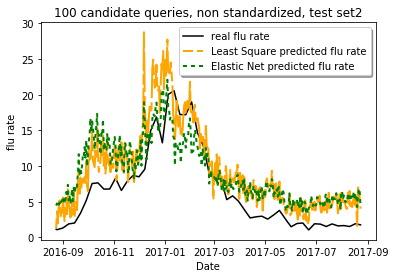

In [17]:
f= plt.figure()
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate',color='black')
#ax.plot(date[4018:],y_pred1,label='Ridge predicted flu rate')
ax.plot(date[4018:],y_pred2,label='Least Square predicted flu rate',dashes=[5,2,20,2], linewidth=2,color='orange')
ax.plot(date[4018:],y_pred3,label='Elastic Net predicted flu rate',dashes=[2,2], linewidth=2,color='green')
# Now add the legend with some customizations.

legend = ax.legend(loc='upper right', shadow=True)
plt.title("100 candidate queries, non standardized, test set2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.savefig("100nostandard_test2.pdf", bbox_inches='tight')

plt.show()



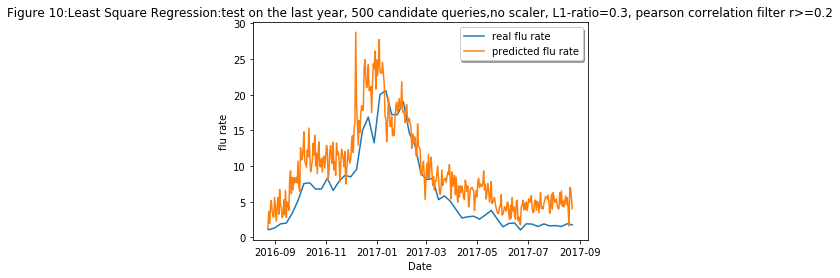

In [16]:
alpha=0
ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ri.fit(train3_X,train3_y)

y_pred1 = ri.predict(test1_X1)

# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],y_pred1,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
plt.title("Figure 10:Least Square Regression:test on the last year, 500 candidate queries,no scaler, L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

## For the last 2 years as the testing set

In [18]:
train_size2 = train2_X.shape[0]
corrs2 = np.zeros((X.shape[1],1))
for i in range(0,X.shape[1]):
    if X.sum(axis=1)[i] == 0:
        corrs2[i] = 0
    else:
        corrs2[i] = np.corrcoef(train2_X.iloc[0:train_size2,i],train2_y.iloc[0:train_size2,0])[0,1]
        
corrs2.shape,X.columns.shape,X.columns[0],X.columns[99]

((100, 1), (100,), ('flu',), ('the flu jab',))

In [19]:
#train2_X0,test2_X0 = corr_filter(train2_X,test2_X,corrs2,0.1)
train2_X1,val2_X1,test2_X1 = corr_filter(train2_X,val2_X,test2_X,corrs2,0.2)
#train2_X2,test2_X2 = corr_filter(train2_X,test2_X,corrs2,0.3)
#train2_X3,test2_X3 = corr_filter(train2_X,test2_X,corrs2,0.4)

In [20]:
#print('For correlation filter r>0.1, we select feature number: ',train2_X0.shape[1])
print('For correlation filter r>0.2, we select feature number: ',train2_X1.shape[1])
#print('For correlation filter r>0.3, we select feature number: ',train2_X2.shape[1])
#print('For correlation filter r>0.4, we select feature number: ',train2_X3.shape[1])

For correlation filter r>0.2, we select feature number:  65


# scaling and modeling
scaler = MinMaxScaler()
train2_X0_scaled = scaler.fit_transform(train2_X0)
test2_X0_scaled = scaler.transform(test2_X0)

train2_X1_scaled = scaler.fit_transform(train2_X1)
test2_X1_scaled = scaler.transform(test2_X1)

train2_X2_scaled = scaler.fit_transform(train2_X2)
test2_X2_scaled = scaler.transform(test2_X2)

train2_X3_scaled = scaler.fit_transform(train2_X3)
test2_X3_scaled = scaler.transform(test2_X3)


para = range(1,100)
para = np.arange(0.01, 10.0, 0.01)
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train1_X1,train1_y,val1_X1,val1_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')

In [20]:
para = range(1,300)
para_l =[0.3]
rmse=100000
mae=1000000
corr=0
## Fixing l1-ratio = 0.3, only tuning alpha.
print('For correlation filter r>=0.2, 212 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        rmse0,mae0,corr0 = eNet(a,l,train2_X1,train2_y,val2_X1,val2_y)
        if rmse0< rmse:
            rmse=rmse0
            mae=mae0
            corr = corr0
            print('========================================')
            print('Best RMSE is updated! ' )
            print('The mean absolute error is: ',mae)
            print('The root mean squared error is: ',rmse)
            print('The correlation is: ',corr)
            print('----------------------------------------')
        

For correlation filter r>=0.2, 212 features are selected
alpha: 1  L1-ratio: 0.3
Nonzero weights: 64 from 65
Best RMSE is updated! 
The mean absolute error is:  4.589126513536702
The root mean squared error is:  8.596378189428645
The correlation is:  0.39878631218135935
----------------------------------------
alpha: 2  L1-ratio: 0.3
Nonzero weights: 61 from 65
Best RMSE is updated! 
The mean absolute error is:  4.524318284711089
The root mean squared error is:  8.406844055307912
The correlation is:  0.40855881708000047
----------------------------------------
alpha: 3  L1-ratio: 0.3
Nonzero weights: 59 from 65
Best RMSE is updated! 
The mean absolute error is:  4.47577900361751
The root mean squared error is:  8.256512599736759
The correlation is:  0.4164159425918245
----------------------------------------
alpha: 4  L1-ratio: 0.3
Nonzero weights: 57 from 65
Best RMSE is updated! 
The mean absolute error is:  4.434376103787817
The root mean squared error is:  8.123365062314313
The cor

Nonzero weights: 28 from 65
Best RMSE is updated! 
The mean absolute error is:  3.988240699563536
The root mean squared error is:  6.5192858485652865
The correlation is:  0.5383033719274766
----------------------------------------
alpha: 30  L1-ratio: 0.3
Nonzero weights: 28 from 65
Best RMSE is updated! 
The mean absolute error is:  3.983743505013778
The root mean squared error is:  6.497039300468979
The correlation is:  0.5403796407099698
----------------------------------------
alpha: 31  L1-ratio: 0.3
Nonzero weights: 26 from 65
Best RMSE is updated! 
The mean absolute error is:  3.98296237540284
The root mean squared error is:  6.485884731913757
The correlation is:  0.5412064821093819
----------------------------------------
alpha: 32  L1-ratio: 0.3
Nonzero weights: 25 from 65
alpha: 33  L1-ratio: 0.3
Nonzero weights: 25 from 65
alpha: 34  L1-ratio: 0.3
Nonzero weights: 25 from 65
alpha: 35  L1-ratio: 0.3
Nonzero weights: 25 from 65
alpha: 36  L1-ratio: 0.3
Nonzero weights: 24 fro

alpha: 170  L1-ratio: 0.3
Nonzero weights: 6 from 65
alpha: 171  L1-ratio: 0.3
Nonzero weights: 6 from 65
alpha: 172  L1-ratio: 0.3
Nonzero weights: 6 from 65
alpha: 173  L1-ratio: 0.3
Nonzero weights: 6 from 65
alpha: 174  L1-ratio: 0.3
Nonzero weights: 6 from 65
alpha: 175  L1-ratio: 0.3
Nonzero weights: 6 from 65
alpha: 176  L1-ratio: 0.3
Nonzero weights: 6 from 65
alpha: 177  L1-ratio: 0.3
Nonzero weights: 6 from 65
alpha: 178  L1-ratio: 0.3
Nonzero weights: 6 from 65
alpha: 179  L1-ratio: 0.3
Nonzero weights: 6 from 65
alpha: 180  L1-ratio: 0.3
Nonzero weights: 6 from 65
alpha: 181  L1-ratio: 0.3
Nonzero weights: 6 from 65
alpha: 182  L1-ratio: 0.3
Nonzero weights: 6 from 65
alpha: 183  L1-ratio: 0.3
Nonzero weights: 6 from 65
alpha: 184  L1-ratio: 0.3
Nonzero weights: 6 from 65
alpha: 185  L1-ratio: 0.3
Nonzero weights: 6 from 65
alpha: 186  L1-ratio: 0.3
Nonzero weights: 6 from 65
alpha: 187  L1-ratio: 0.3
Nonzero weights: 6 from 65
alpha: 188  L1-ratio: 0.3
Nonzero weights: 5 f

In [23]:
## tuned alpha based on validation set, then measure the performance for test set.
## Fixing l1-ratio = 0.3
para = [31]
para_l=[0.3]
rmse=100000
mae=1000000
corr=0
print('For correlation filter r>=0.2, 212 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        rmse0,mae0,corr0 = eNet(a,l,train4_X,train4_y,test2_X1,test2_y)
        if rmse0< rmse:
            rmse=rmse0
            mae=mae0
            corr = corr0
            print('========================================')
            print('Best RMSE is updated! ' )
            print('The mean absolute error is: ',mae)
            print('The root mean squared error is: ',rmse)
            print('The correlation is: ',corr)
            print('----------------------------------------')

For correlation filter r>=0.2, 212 features are selected
alpha: 31  L1-ratio: 0.3
Nonzero weights: 26 from 65
Best RMSE is updated! 
The mean absolute error is:  2.905164800697123
The root mean squared error is:  3.562160389766897
The correlation is:  0.8898278748225814
----------------------------------------


In [24]:
print(train2_X1.shape,val2_X1.shape)
train4_X = train2_X1.append(val2_X1)
train4_y = train2_y.append(val2_y)
train4_X.shape,train4_y.shape

(3293, 65) (360, 65)


((3653, 65), (3653, 1))

In [25]:

para =np.arange(0, 100000000, 100000)
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train2_X1,train2_y,val2_X1,val2_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')

alpha: 0
Best RMSE is updated! 
The mean absolute error is:  4.662362333373596
The root mean squared error is:  8.81456770208069
The correlation is:  0.38774823572243183
----------------------------------------
alpha: 100000
Best RMSE is updated! 
The mean absolute error is:  4.591857598136086
The root mean squared error is:  8.64041343622203
The correlation is:  0.39526366610061797
----------------------------------------
alpha: 200000
Best RMSE is updated! 
The mean absolute error is:  4.53706063543807
The root mean squared error is:  8.49996841277368
The correlation is:  0.40124457098043126
----------------------------------------
alpha: 300000
Best RMSE is updated! 
The mean absolute error is:  4.493238673599797
The root mean squared error is:  8.380326547085561
The correlation is:  0.4063543815673922
----------------------------------------
alpha: 400000
Best RMSE is updated! 
The mean absolute error is:  4.455220004258642
The root mean squared error is:  8.27524868352532
The corr

Best RMSE is updated! 
The mean absolute error is:  4.132505535044097
The root mean squared error is:  7.088259954069637
The correlation is:  0.4727343983346851
----------------------------------------
alpha: 3400000
Best RMSE is updated! 
The mean absolute error is:  4.130027102923582
The root mean squared error is:  7.072498559744126
The correlation is:  0.4737068333023373
----------------------------------------
alpha: 3500000
Best RMSE is updated! 
The mean absolute error is:  4.127663224545893
The root mean squared error is:  7.057471410683507
The correlation is:  0.4746342617975058
----------------------------------------
alpha: 3600000
Best RMSE is updated! 
The mean absolute error is:  4.125446295986587
The root mean squared error is:  7.043138666682697
The correlation is:  0.47551847475013803
----------------------------------------
alpha: 3700000
Best RMSE is updated! 
The mean absolute error is:  4.123293455082895
The root mean squared error is:  7.029463158740976
The correl

Best RMSE is updated! 
The mean absolute error is:  4.138359022590473
The root mean squared error is:  6.776052487003595
The correlation is:  0.48887016053048676
----------------------------------------
alpha: 8000000
Best RMSE is updated! 
The mean absolute error is:  4.139098871722718
The root mean squared error is:  6.774078446385414
The correlation is:  0.48884479327585617
----------------------------------------
alpha: 8100000
Best RMSE is updated! 
The mean absolute error is:  4.1398305822624835
The root mean squared error is:  6.7722019014291615
The correlation is:  0.4888108681847811
----------------------------------------
alpha: 8200000
Best RMSE is updated! 
The mean absolute error is:  4.140554259148586
The root mean squared error is:  6.770419484792179
The correlation is:  0.48876865677172726
----------------------------------------
alpha: 8300000
Best RMSE is updated! 
The mean absolute error is:  4.141270004541686
The root mean squared error is:  6.768727970112507
The co

alpha: 11400000
alpha: 11500000
alpha: 11600000
alpha: 11700000
alpha: 11800000
alpha: 11900000
alpha: 12000000
alpha: 12100000
alpha: 12200000
alpha: 12300000
alpha: 12400000
alpha: 12500000
alpha: 12600000
alpha: 12700000
alpha: 12800000
alpha: 12900000
alpha: 13000000
alpha: 13100000
alpha: 13200000
alpha: 13300000
alpha: 13400000
alpha: 13500000
alpha: 13600000
alpha: 13700000
alpha: 13800000
alpha: 13900000
alpha: 14000000
alpha: 14100000
alpha: 14200000
alpha: 14300000
alpha: 14400000
alpha: 14500000
alpha: 14600000
alpha: 14700000
alpha: 14800000
alpha: 14900000
alpha: 15000000
alpha: 15100000
alpha: 15200000
alpha: 15300000
alpha: 15400000
alpha: 15500000
alpha: 15600000
alpha: 15700000
alpha: 15800000
alpha: 15900000
alpha: 16000000
alpha: 16100000
alpha: 16200000
alpha: 16300000
alpha: 16400000
alpha: 16500000
alpha: 16600000
alpha: 16700000
alpha: 16800000
alpha: 16900000
alpha: 17000000
alpha: 17100000
alpha: 17200000
alpha: 17300000
alpha: 17400000
alpha: 17500000
alpha: 1

alpha: 63300000
alpha: 63400000
alpha: 63500000
alpha: 63600000
alpha: 63700000
alpha: 63800000
alpha: 63900000
alpha: 64000000
alpha: 64100000
alpha: 64200000
alpha: 64300000
alpha: 64400000
alpha: 64500000
alpha: 64600000
alpha: 64700000
alpha: 64800000
alpha: 64900000
alpha: 65000000
alpha: 65100000
alpha: 65200000
alpha: 65300000
alpha: 65400000
alpha: 65500000
alpha: 65600000
alpha: 65700000
alpha: 65800000
alpha: 65900000
alpha: 66000000
alpha: 66100000
alpha: 66200000
alpha: 66300000
alpha: 66400000
alpha: 66500000
alpha: 66600000
alpha: 66700000
alpha: 66800000
alpha: 66900000
alpha: 67000000
alpha: 67100000
alpha: 67200000
alpha: 67300000
alpha: 67400000
alpha: 67500000
alpha: 67600000
alpha: 67700000
alpha: 67800000
alpha: 67900000
alpha: 68000000
alpha: 68100000
alpha: 68200000
alpha: 68300000
alpha: 68400000
alpha: 68500000
alpha: 68600000
alpha: 68700000
alpha: 68800000
alpha: 68900000
alpha: 69000000
alpha: 69100000
alpha: 69200000
alpha: 69300000
alpha: 69400000
alpha: 6

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.3, 154 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train2_X2,train2_y,test2_X2,test2_y))

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.4, 105 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train2_X3,train2_y,test2_X3,test2_y))

In [26]:
## tuned alpha based on validation set, then measure the performance for test set.
## Fixing l1-ratio = 0.3
para = [11200000,0]
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train4_X,train4_y,test2_X1,test2_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')

alpha: 11200000
Best RMSE is updated! 
The mean absolute error is:  3.2597546347017157
The root mean squared error is:  3.8942549608656982
The correlation is:  0.8713641164901731
----------------------------------------
alpha: 0
Best RMSE is updated! 
The mean absolute error is:  2.664707502350602
The root mean squared error is:  3.388036926639602
The correlation is:  0.8939781590666764
----------------------------------------


In [27]:
alpha=11200000
ri2 = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ri2.fit(train4_X,train4_y)

y_pred3 = ri2.predict(test2_X1)

alpha=0
ls2 = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ls2.fit(train4_X,train4_y)

y_pred4 = ls2.predict(test2_X1)


a = 31
l=0.3
en2 = ElasticNet(alpha=a, l1_ratio=l, normalize=False,max_iter=10000)
en2.fit(train4_X,train4_y)

y_pred5 = en2.predict(test2_X1)

<Figure size 432x288 with 0 Axes>

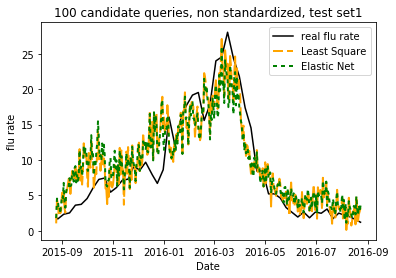

In [40]:
f= plt.figure()

# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate',color='black')
#ax.plot(date[3653:4018],y_pred3,label='Ridge predicted flu rate')
ax.plot(date[3653:4018],y_pred4,label='Least Square',dashes=[5,2,20,2], linewidth=2,color='orange')
ax.plot(date[3653:4018],y_pred5,label='Elastic Net',dashes=[2,2], linewidth=2,color='green')

# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=False)
plt.title("100 candidate queries, non standardized, test set1")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.savefig("100nostandard_test1.pdf", bbox_inches='tight')

plt.show()




In [ ]:
alpha=0
ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ri.fit(train4_X,train4_y)

y_pred2 = ri.predict(test2_X1)

# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:4018],y_pred2,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
plt.title("Figure 12:Least Square Regression:test on the second last year, 500 candidate queries,no scaler,L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()